In [1]:
# 10/03/2022 Luís

# In this notebook, in addition to the "train_HGO_diff" notebook,
# the parameters [c, κ, k1, k2, θ] were normalized using sklearn.preprocessing.StandardScaler()
# This way, each of the components of the vector is normaly distributed around 0 with a standard deviation of 1.

# For example, for c, mean = 20.59518917 and std = 12.4038047.
# A original value of 13.78172437 will be transformed into -0.54930442. (z = (x – mean) / std)

# Lower losses were achieved with this normalization.



# 28/03/2022 Luís

# In this notebook I use a total set of 537824 (14^5) curves. The model only predicts the stress value, as the stretch values
# were the same for all curves.

# In the end of the notebook, the test labels and model outputs are transformed back into absolute coordinates
# (the model is trained on the differences between stress values) and I apply evaluation metrics to the model.

# Three metrics are applied: 

# MSE (average error across all test curves)

# R^2 score (average score across all test curves)
#           (accuracy score defined as the percentage of curves that have a score above an accepteble treshold)

# Relative error (average error across all test curves)
#                (accuracy score defined as the percentage of curves that have an error below an accepteble treshold)

# I have a spreadsheet with these metrics applied on similar models which were trained on 10^5; 12^5; 14^5 and 16^5 curves.

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import ast
import seaborn as sns
from sklearn.model_selection import train_test_split

In [3]:
import pandas as pd
import random

import sympy as sym
from sympy.physics.quantum import TensorProduct

import numpy as np
from matplotlib import pyplot as plt

pd.set_option('display.max_rows', None)

In [4]:
from sklearn import preprocessing
from sklearn.metrics import r2_score

In [5]:
def plot_the_loss_curve(epochs, mse_training, mse_validation):

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Loss")

  plt.plot(epochs[0:], mse_training[0:], label="Training Loss")
  plt.plot(epochs[0:], mse_validation[0:], label="Validation Loss")
  plt.legend()
  
  # We're not going to plot the first epoch, since the loss on the first epoch
  # is often substantially greater than the loss for other epochs.
  merged_mse_lists = mse_training[1:] + mse_validation[1:]
  highest_loss = max(merged_mse_lists)
  lowest_loss = min(merged_mse_lists)
  delta = highest_loss - lowest_loss
  print(delta)

  top_of_y_axis = highest_loss + (delta * 0.05)
  bottom_of_y_axis = lowest_loss - (delta * 0.05)
   
  plt.ylim([bottom_of_y_axis, top_of_y_axis])
  plt.show() 

### Import data

#### In this case we have 537824 total curves (= 14^5)

In [6]:
X = np.load('X_run_14_noise.npy')
y = np.load('y_run_14_noise.npy')

In [7]:
ninc = np.shape(y)[1] # number of points per curve, in this case ninc = 10

### We will normalize X now

In [8]:
print(X[0])  # Parameters for curve 0 before transformation

[30.81297752  0.2435848   1.54661867  2.04551152 53.45259955]


In [9]:
print(np.average(X, axis = 0))

[20.57050417  0.21648251  2.55988876  2.55959591 45.46275544]


In [10]:
print(np.std(X, axis = 0))

[12.09618738  0.07205416  1.51875999  1.51893211 27.1478249 ]


In [11]:
# Normalization of the input data
scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)

In [12]:
print(X[0])  # Parameters for curve 0 after transformation

[ 0.84675221  0.37613774 -0.66716933 -0.33845119  0.29430881]


### Next we will transform y such that it will contain the differences between its successive elements.

In [13]:
y[0] # curve 0 before transformation

array([[ 1.        ,  0.        ],
       [ 1.06666667,  6.17378729],
       [ 1.13333333, 12.40239523],
       [ 1.2       , 18.72775321],
       [ 1.26666667, 25.18389393],
       [ 1.33333333, 31.79942379],
       [ 1.4       , 38.59961383],
       [ 1.46666667, 45.60839757],
       [ 1.53333333, 52.85057093],
       [ 1.6       , 60.35458434]])

In [14]:
np.shape(y)

(537824, 10, 2)

#### We will not use the stretch values in this model as input of our model. They will be saved in a vector (x_vec), as they are the same for every curve.

In [15]:
x_vec = np.array(y[0,:,0])
x_vec

array([1.        , 1.06666667, 1.13333333, 1.2       , 1.26666667,
       1.33333333, 1.4       , 1.46666667, 1.53333333, 1.6       ])

In [16]:
for i in range(len(y)):
    y_diff = np.zeros(np.shape(y[0]))
    for j in range(len(y[0])-1):
        y_diff[j+1] = y[i][j+1]-y[i][j]
    #y_diff[0] = [1,0]
    y[i] = y_diff

y = y[:,1:,1]
    
y[0] # curve 0 after transformation

array([6.17378729, 6.22860794, 6.32535798, 6.45614072, 6.61552986,
       6.80019003, 7.00878374, 7.24217336, 7.50401341])

In [17]:
np.shape(y)

(537824, 9)

### Now we are ready to seperate our data into a training set and a test set

In [19]:
#let's save 10% of the data for testing. these curves won't be part of the model training 
test_split=0.1
x_train, x_test,y_train,y_test = train_test_split(X, y, test_size = test_split)
#let's check the array shapes: 
print('Input data')
print('Training set: ',x_train.shape)
print('Test set: ',x_test.shape)
print(' ')
print('Features')
print('Training set: ',y_train.shape)
print('Test set: ',y_test.shape)

#reshape for keras training
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1]))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1]))
#shuffle data
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]


Input data
Training set:  (484041, 5)
Test set:  (53783, 5)
 
Features
Training set:  (484041, 9)
Test set:  (53783, 9)


In [20]:
np.shape(x_train)

(484041, 5)

In [21]:
np.shape(y_train)

(484041, 9)

### And now we can build our model and train it

In [22]:
# Set the hyperparameters
VALIDATION_SPLIT = 0.2
LEARNING_RATE = 0.00005
BATCH_SIZE = 256
EPOCHS = 40
INPUT_SHAPE = x_train.shape[1:]
OUTPUT_SHAPE = y_train.shape[1:]

# Set the model's architechture
inputs = keras.Input(shape=INPUT_SHAPE)

dense = layers.Dense(512, activation="relu")
x = dense(inputs)

dense = layers.Dense(512, activation="relu")
x = dense(x)

dense = layers.Dense(512, activation="relu")
x = dense(x)

dropout = tf.keras.layers.Dropout(0.2)
x = dropout(x)

outputs = layers.Dense(9)(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="model")


# Compile, define the loss function, the optimizer and other metrics
model.compile(
    loss = tf.keras.losses.Huber(),
   # optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE, decay = LEARNING_RATE/EPOCHS),
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    metrics=["mean_squared_error"],
)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5)]               0         
_________________________________________________________________
dense (Dense)                (None, 512)               3072      
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 9)                 4617      
Total params: 533,001
Trainable params: 533,001
Non-trainable params: 0
_______________________________________________________

In [24]:
callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

history=model.fit(
    x_train,
    y_train,
    validation_split=VALIDATION_SPLIT,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
)

test_loss, test_acc = model.evaluate(x_test, y_test)

#print("Test accuracy", test_acc)
print("Test loss", test_loss)

Epoch 1/40
1513/1513 [==============================] - 30s 20ms/step - loss: 2.2418 - mean_squared_error: 15308.1797 - val_loss: 1.9178 - val_mean_squared_error: 19764.1152
Epoch 2/40
1513/1513 [==============================] - 31s 20ms/step - loss: 1.8739 - mean_squared_error: 12957.4189 - val_loss: 1.6237 - val_mean_squared_error: 17436.9023
Epoch 3/40
1513/1513 [==============================] - 31s 21ms/step - loss: 1.6023 - mean_squared_error: 11133.1943 - val_loss: 1.4114 - val_mean_squared_error: 15669.6348
Epoch 4/40
1513/1513 [==============================] - 31s 21ms/step - loss: 1.3886 - mean_squared_error: 9628.2324 - val_loss: 1.2395 - val_mean_squared_error: 14135.4697
Epoch 5/40
1513/1513 [==============================] - 30s 20ms/step - loss: 1.2288 - mean_squared_error: 8282.8193 - val_loss: 1.1214 - val_mean_squared_error: 12510.6494
Epoch 6/40
1513/1513 [==============================] - 30s 20ms/step - loss: 1.0914 - mean_squared_error: 7233.1680 - val_loss: 0.9

1.6213792860507965


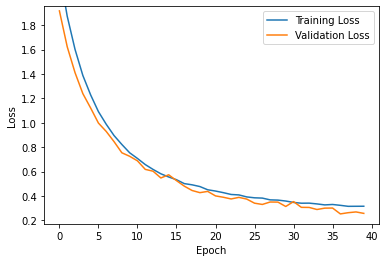

In [25]:
epochs = history.epoch

hist = history.history

plot_the_loss_curve(epochs, hist["loss"], 
                    hist["val_loss"])

In [26]:
model.predict(x_test[0:1])[0]

array([6.2552557, 6.318471 , 6.4241376, 6.5651484, 6.7294183, 6.913353 ,
       7.10479  , 7.3293147, 7.517553 ], dtype=float32)

In [27]:
y_test[0:1][0]

array([6.24721731, 6.30346258, 6.40455942, 6.54058206, 6.70374001,
       6.88791297, 7.0883236 , 7.30129024, 7.52402853])

In [28]:
np.shape(model.predict(x_test[0:1])[0])

(9,)

In [29]:
x_vec

array([1.        , 1.06666667, 1.13333333, 1.2       , 1.26666667,
       1.33333333, 1.4       , 1.46666667, 1.53333333, 1.6       ])

In [30]:
def plot_real_curves(k):
    
    pred_diff = model.predict(x_test[k:k+1])[0]
    pred = np.zeros([len(pred_diff)+1])
    pred[0] = 0
    for i in range(len(pred_diff)):
        pred[i+1] = pred_diff[i] + pred[i]

    plt.plot(x_vec,pred, "--",  color = "r", label = "prediction")

    
    true_dif = y_test[k:k+1][0]
    true = np.zeros([len(true_dif)+1])
    true[0] = 0
    for i in range(len(pred_diff)):
        true[i+1] = true_dif[i] + true[i]

    plt.plot(x_vec,true, color = "g", label = "real")

    plt.xlabel("λ")
    plt.ylabel("σ")
    plt.legend()
    plt.show()

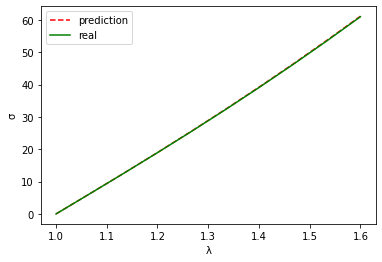

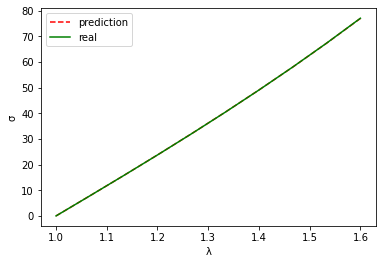

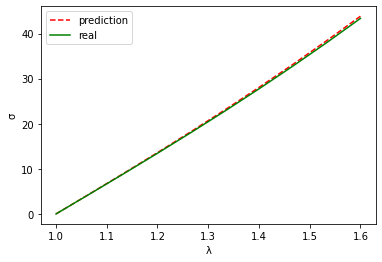

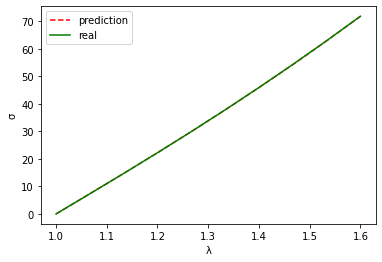

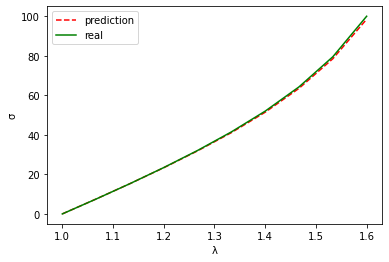

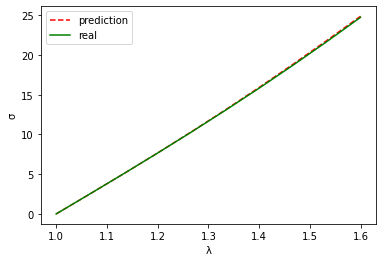

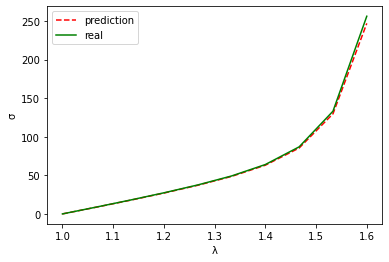

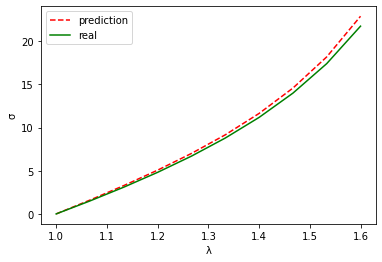

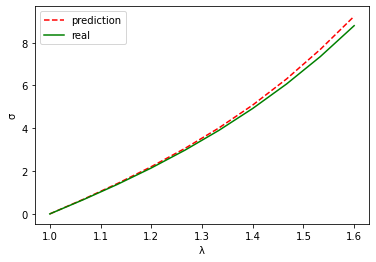

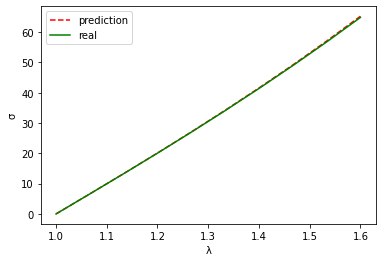

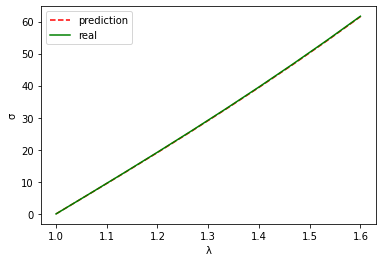

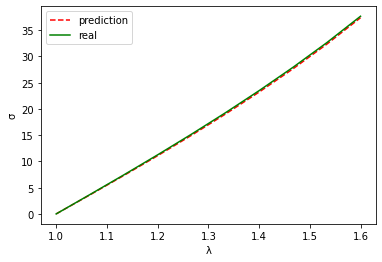

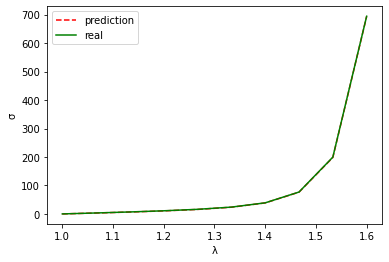

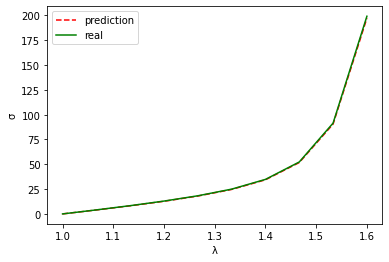

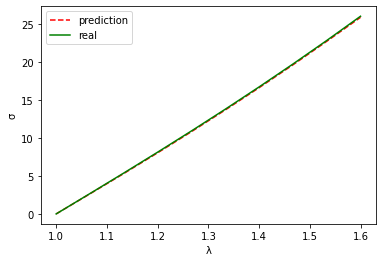

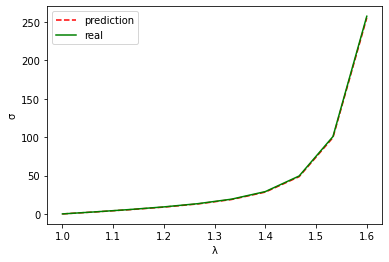

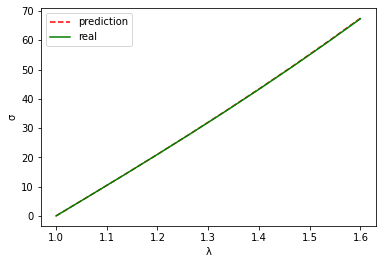

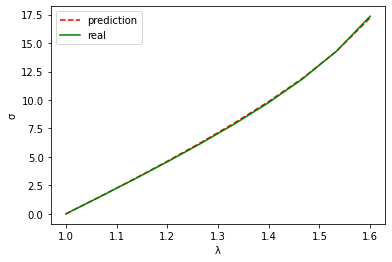

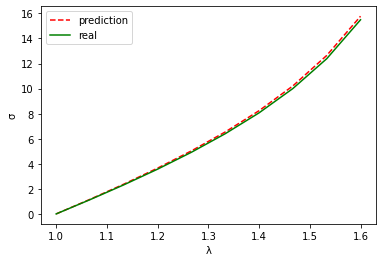

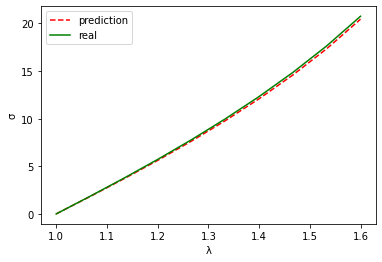

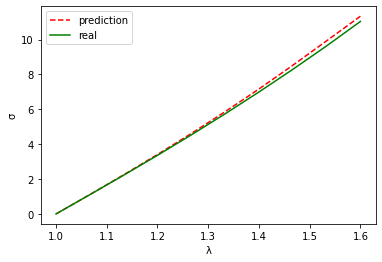

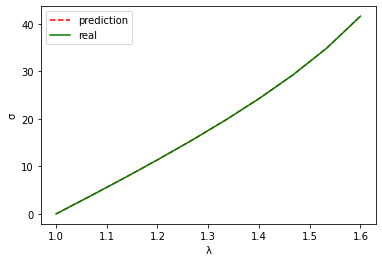

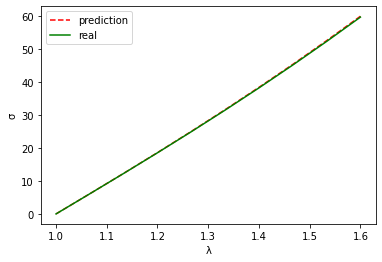

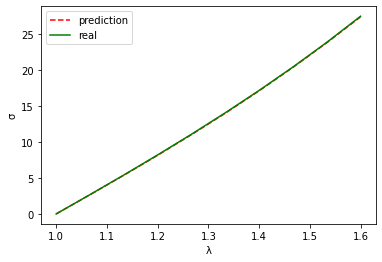

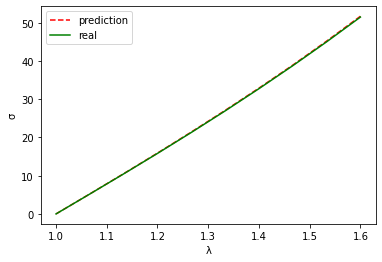

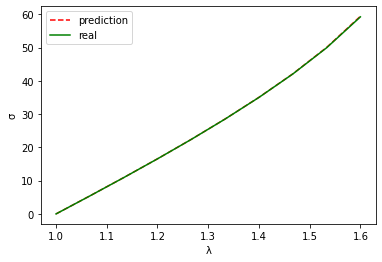

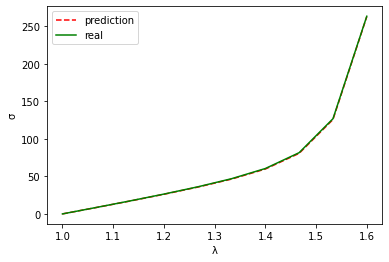

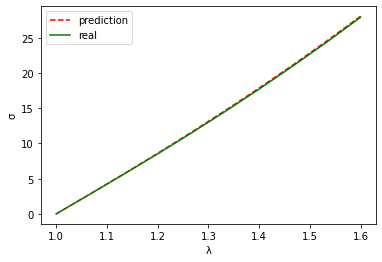

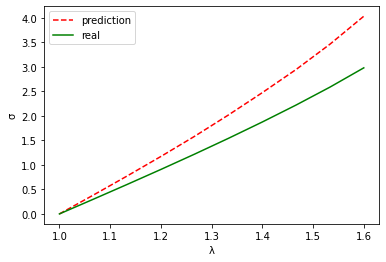

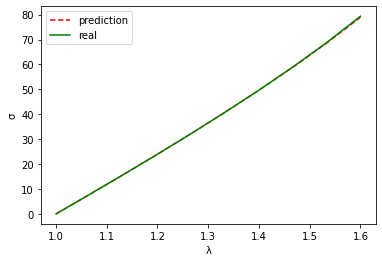

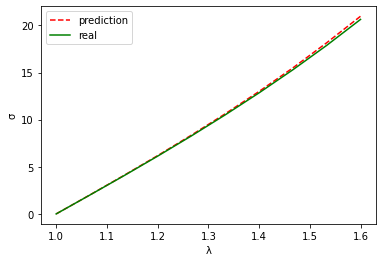

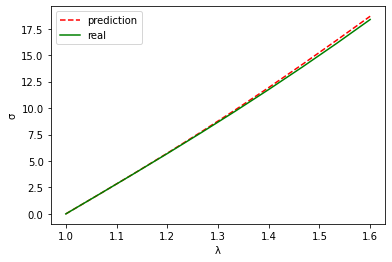

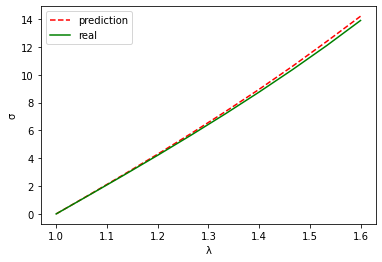

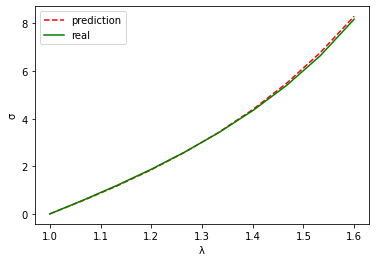

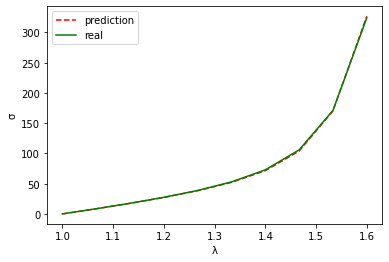

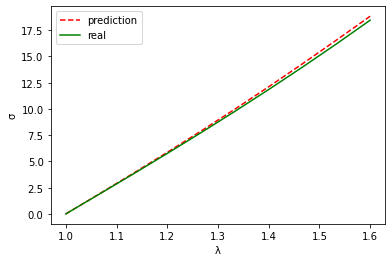

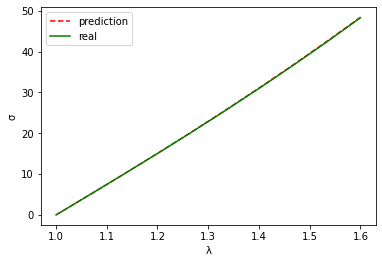

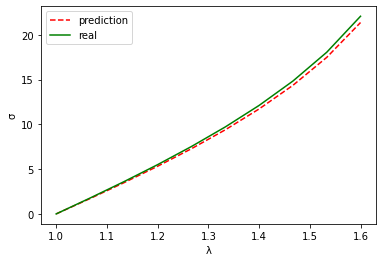

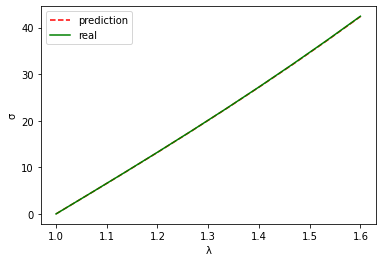

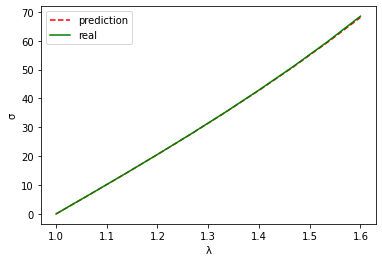

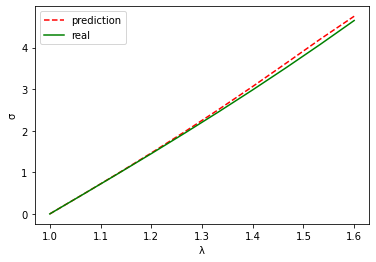

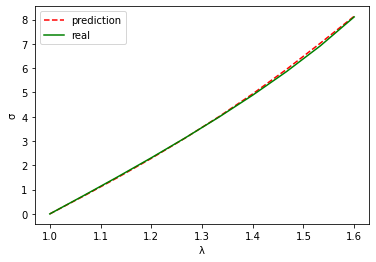

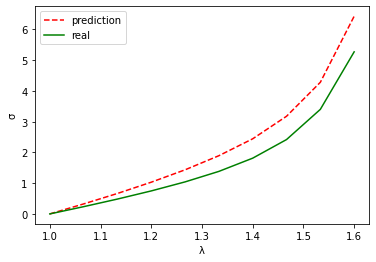

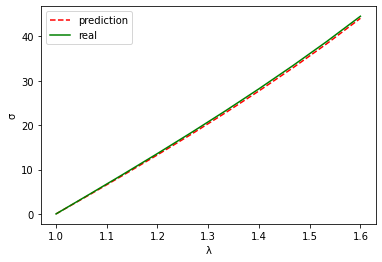

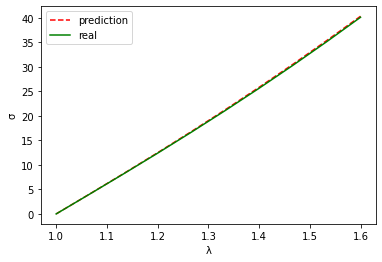

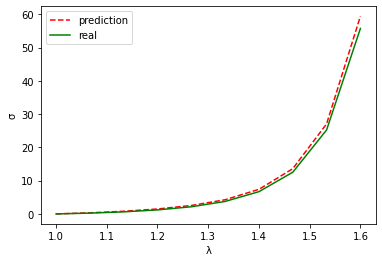

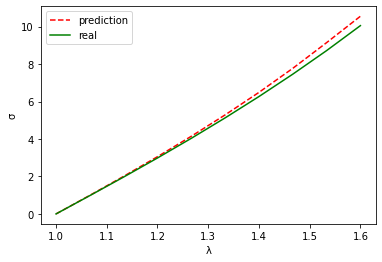

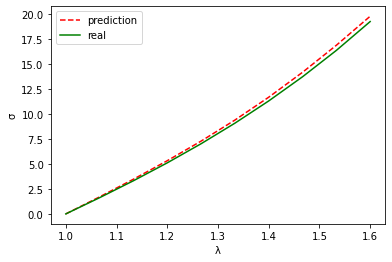

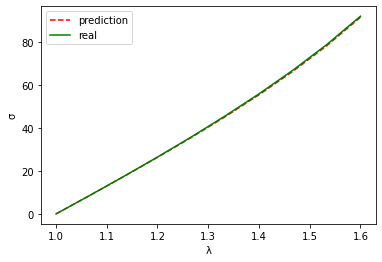

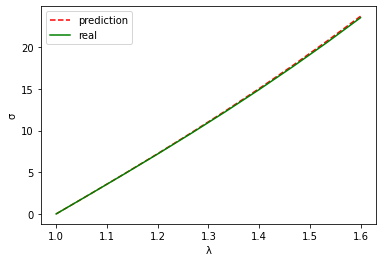

In [31]:
for i in range(50): plot_real_curves(i)

In [43]:
def rel_error(true,guess):
    err = np.abs(true-guess)/np.abs(true)
    return err

### Convert the curves used for testing back into absolute coordinates

In [85]:
def convert_back_curves(y_diff):
    ### Transforms the model's output (which is written in terms of differences between points) back into absolute coordinates.
    
    abs_curves = np.zeros([np.shape(y_diff)[0],np.shape(y_diff)[1]+1])    
    for i in range(len(y_diff)):
        y_abs = np.zeros(np.shape(y_diff)[1]+1)
        for j in range(len(y_diff[0])):
            y_abs[j+1] = y_diff[i][j]+y_abs[j]
        abs_curves[i] = y_abs
    
    return abs_curves

In [88]:
pred_curves = convert_back_curves(model.predict(x_test))
true_curves = convert_back_curves(y_test)

### Model evaluation metrics applied on the test set of curves

In [126]:
# RELATIVE ERROR CRITERIA
c = np.average(rel_error(true_curves[:,1:], pred_curves[:,1:]),axis = 1)

print("Average relative error", np.round(np.average(c)*100,decimals = 2),"%")

treshold = 0.05
print("Relative error accuracy =",np.round(100*len(c[c<treshold])/len(c), decimals = 2),"%, for a treshold of",treshold*100,"%")
print('\n')

# R^2 SCORE CRITERIA
d = r2_score(np.transpose(true_curves[:,1:]), np.transpose(pred_curves[:,1:]), multioutput='raw_values')

print("Average R^2 score: ", np.round(np.average(d),decimals = 4))

treshold = 0.95
print("R^2 Accuracy =", np.round(100*len(d[d>treshold])/len(d),decimals=2), "%, for a treshold of", treshold)
print('\n')

# MSE CRITERIA
mse = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)
e = mse(true_curves[:,1:], pred_curves[:,1:]).numpy()

print("Average MSE score: ", np.round(np.average(e),decimals = 2),'\n')

Average relative error 4.35 %
Relative error accuracy = 92.53 %, for a treshold of 5.0 %


Average R^2 score:  0.8766
R^2 Accuracy = 97.67 %, for a treshold of 0.95


Average MSE score:  693.13 



### Best and worst curves according to each criteria

Curve nº: 41002 . Worst curve by relative error criteria


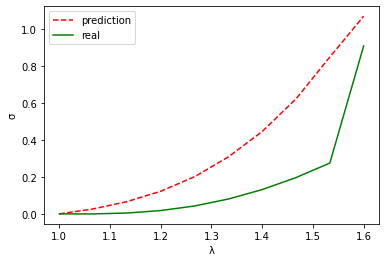

In [105]:
print("Curve nº:", np.argmax(c), ". Worst curve by relative error criteria")
plot_real_curves(np.argmax(c))

Curve nº: 20394 . Best curve by relative error criteria


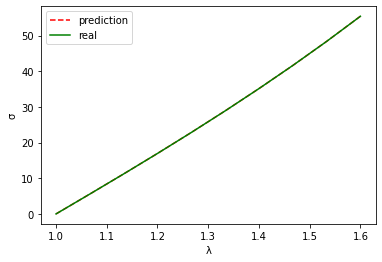

In [106]:
print("Curve nº:", np.argmin(c), ". Best curve by relative error criteria")
plot_real_curves(np.argmin(c))

Curve nº: 6734 . Worst curve by R^2 criteria


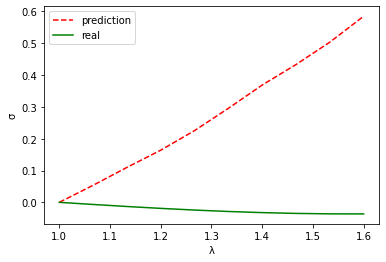

In [103]:
print("Curve nº:", np.argmin(d), ". Worst curve by R^2 criteria")
plot_real_curves(np.argmin(d))

Curve nº: 20394 . Best curve by R^2 criteria


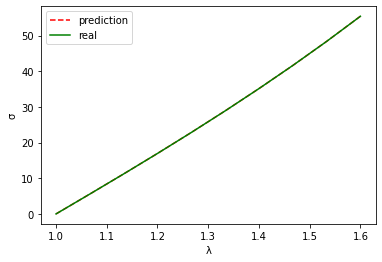

In [104]:
print("Curve nº:", np.argmax(d), ". Best curve by R^2 criteria")
plot_real_curves(np.argmax(d))

Curve nº: 7774 . Best curve by MSE criteria


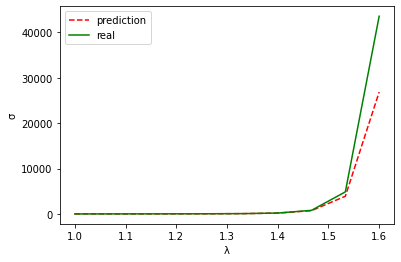

In [127]:
print("Curve nº:", np.argmax(e), ". Best curve by MSE criteria")
plot_real_curves(np.argmax(e))

Curve nº: 20394 . Best curve by MSE criteria


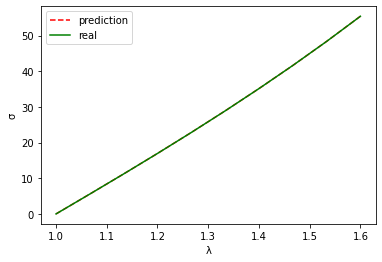

In [123]:
print("Curve nº:", np.argmin(e), ". Best curve by MSE criteria")
plot_real_curves(np.argmin(e))